Machine Learning for Kaggle House Price prediction
==================

This notebook contains data preprocessing, machine learning and finally an ensemble to create the prediction.

See [my blog](http://jorivanlier.nl/blog/2017/08/26/kaggle-house-price-prediction.html) for details.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import seaborn as sns

from preprocess import prep_data
from utils import rmsle, rmsle_sk, create_submission, create_submission_from_ensemble, \
                  sqrt_transform_helper, log_transform_helper, ihs_transform_helper
from crossval import calc_kfold_score, gridcv
    
%matplotlib inline

In [3]:
COL_Y = 'SalePrice'

## Load data

In [4]:
df_train = pd.read_csv('data/train.csv', index_col='Id')
df_test = pd.read_csv('data/test.csv', index_col='Id')
df_comb = pd.concat((df_train, df_test))
df_comb = df_comb.sample(frac=1)  # Shuffle - just in case

print("n:", len(df_comb), "n_cols: ", len(df_comb.columns))

n: 2919 n_cols:  80


## Some mandatory conversions

These conversion must be performed. Reasons include data that's read incorrectly, has too many missing values for our imputation algorithm to handle, or other code relies on it having been performed.

In [5]:
# The other code assumes log transform on the output variable so it's kind of non-optional:
df_comb[COL_Y] = np.log(df_comb[COL_Y].values)

# Missing values for the following columns indicate that the property doesn't have it 
# (according to the Kaggle docs):
cols_nan_means_missing = ['Alley', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 
                          'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for col in cols_nan_means_missing:
    df_comb.loc[df_comb[col].isnull(), col] = 'N/A'

# Basement is a bit trickier because sometimes only one of the fields is missing, but that doesn't mean that
# there is no basement.
bsmt_cols = [c for c in df_comb.columns if 'Bsmt' in c]
bsmt_cols_num = [c for c in bsmt_cols if df_comb[c].dtype != 'object']
bsmt_cols_cat = set(bsmt_cols) - set(bsmt_cols_num)
df_comb.loc[(df_comb['BsmtQual'].isnull()) & (df_comb['BsmtCond'].isnull()), bsmt_cols_cat] = 'NoBsmt'
df_comb.loc[(df_comb['BsmtCond'] == 'NoBsmt'), bsmt_cols_num] = 0

# Garage as well:
gar_cols = {c for c in df_comb.columns if 'garage' in c.lower()}
gar_cols_num = {c for c in gar_cols if df_comb[c].dtype != 'object'}
gar_cols_cat = gar_cols - gar_cols_num
# I don't really know what's best for missing values in GarageYrBlt. Will let KNN impute something:
gar_cols_num.remove('GarageYrBlt')  
cond_nogar = (df_comb['GarageArea'] == 0) | (df_comb['GarageArea'].isnull())
df_comb.loc[cond_nogar, gar_cols_cat] = 'NoGarage'
df_comb.loc[cond_nogar, gar_cols_num] = 0

# Masonry veneer, assuming that a property doesn't have it if both fields are null.
df_comb.loc[(df_comb['MasVnrArea'].isnull()) & (df_comb['MasVnrType'].isnull()), 
            ['MasVnrType', 'MasVnrArea']] = ['None', 0]

# Too many missing values or not enough distinct values to be useful:
# (Yes, this includes columns where I put N/A earlier, I might change my mind about dropping them and 
#  will want to keep the N/A in that case).
df_comb = df_comb.drop(['Alley', 'MiscFeature', 'Utilities', 'Electrical', 'PoolArea', 'PoolQC'], axis=1)  

# MSSubClass is a categorical variable with numeric categories. Avoid treating it as
# numeric/ordinal:
df_comb.loc[:, 'MSSubClass'] = df_comb['MSSubClass'].astype('str')  

## Data preprocessing  1 - manual feature engineering

Transformations are registered as functions that take 1 argument, a DataFrame, and return a DataFrame. They're added to a list and then executed sequentially.
By specifying them as functions, rather than executing them directly, we can test what their impact is on the CV score. We'll then only use the ones that actually improve the score.

There isn't much of an ordering in here. I started following the order in Kaggle's `data_description.txt`, but soon realised that that would take too much time, so I started grouping some similar columns and treating them in the same way. Anyway - the order corresponds to the explorative analysis notebook. That notebook contains the rationale for these transformations.

In [6]:
transformations = []

In [7]:
def trans_mssubclass(df):
    col = 'MSSubClass'
    df.loc[df[col].isin(['40', '160']), col] = '40_160'
    df.loc[df[col].isin(['70', '20', '75']), col] = '70_20_75'
    df.loc[df[col].isin(['190', '50', '90']), col] = '190_50_90'
    df.loc[df[col].isin(['30', '45', '180']), col] = '30_45_180'
    df.loc[df[col] == '150', col] = np.nan
    return df
transformations.append(trans_mssubclass)

In [8]:
def trans_lotshape(df):
    old_col = 'LotShape'
    new_col = 'RegularLotShape'
    df.loc[df[old_col] == 'Reg', new_col] = 1
    df.loc[df[old_col] == 'IR1', new_col] = 0
    df.loc[df[old_col] == 'IR2', new_col] = 0
    df.loc[df[old_col] == 'IR3', new_col] = 0
    df[new_col] = df[new_col].astype(int)
    df = df.drop(old_col, axis=1)
    return df
transformations.append(trans_lotshape)

In [9]:
def trans_landcontour(df):
    df.loc[:, 'LandLvlOrBnk'] = 0
    df.loc[df['LandContour'].isin(('Lvl','Bnk')), 'LandLvlOrBnk'] = 1
    df = df.drop('LandContour', axis=1)
    return df
transformations.append(trans_landcontour)

In [10]:
def trans_lotconfig(df):
    df.loc[df['LotConfig'].isin(('FR3','CulDSac')), 'LotConfig'] = 'FR3_or_CulDSac'
    df.loc[df['LotConfig'].isin(('Inside','Corner')), 'LotConfig'] = 'Inside_or_Corner'
    return df
transformations.append(trans_lotconfig)

In [11]:
def trans_landslope(df):
    old_col_name = 'LandSlope'
    new_col_name = 'LandSlopeGtl'
    df.loc[:, new_col_name] = 0
    df.loc[df[old_col_name].isin(['Gtl']), new_col_name] = 1
    df = df.drop(old_col_name, axis=1)
    return df
transformations.append(trans_landslope)

In [12]:
def trans_neighborhood(df):
    old_col_name = 'Neighborhood'
    new_col_cheap = 'CheapNeighborhood'
    new_col_exp = 'ExpensiveNeighborhood'
    df.loc[:, new_col_cheap] = 0
    df.loc[:, new_col_exp] = 0
    
    nb_sp = df_comb.groupby('Neighborhood')[['SalePrice']].median()
    df.loc[df[old_col_name].isin(
        nb_sp[nb_sp['SalePrice'] > 200000]
            .index.get_level_values(0).values), new_col_exp] = 1
    
    df.loc[df[old_col_name].isin(
        nb_sp[nb_sp['SalePrice'] < 160000]
            .index.get_level_values(0).values), new_col_cheap] = 1
    
    df = df.drop(old_col_name, axis=1)
    return df
transformations.append(trans_neighborhood)

In [13]:
def trans_add_is_new(df):
    col = 'IsNew'
    df.loc[:, col] = 0
    df.loc[(df['YearBuilt'] == df['YrSold']) | 
            (df['YearBuilt']-1 == df['YrSold']), col] = 1
    return df
transformations.append(trans_add_is_new)

In [14]:
def trans_add_remodel(df):
    col = 'RecentRemodel'
    df.loc[:, col] = 0
    df.loc[(df['YearRemodAdd'] >= df['YrSold']), col] = 1
    return df
transformations.append(trans_add_remodel)

In [15]:
def trans_fix_year_remod_add(df):
    df.loc[(df['YearRemodAdd'] == 1950) & 
            (df['YearBuilt'] < 1950), 'YearBuilt'] = df['YearBuilt']
    return df
transformations.append(trans_fix_year_remod_add)

In [16]:
def trans_del_yrsold(df):
    return df.drop('YrSold', axis=1)
transformations.append(trans_del_yrsold)

In [17]:
def trans_del_mosold(df):
    return df.drop('MoSold', axis=1)
transformations.append(trans_del_mosold)

In [18]:
def trans_del_roofmatl(df):
    return df.drop('RoofMatl', axis=1)
transformations.append(trans_del_roofmatl)

In [19]:
def trans_roof_style(df):
    col = 'RoofStyle'                                         
    df.loc[df[col].isin(('Gambrel','Gable')), col] = 'GG'
    df.loc[df[col].isin(('Mansard','Hip', 'Flat', 'Shed')), col] = 'MHFS'
    return df
transformations.append(trans_roof_style)

In [20]:
def trans_condition(df):
    col1 = 'Condition1'
    col2 = 'Condition2'
    
    col_art = 'CloseToArtery'
    df.loc[:, col_art] = 0
    df.loc[(df[col1] == 'Artery') | 
            (df[col2] == 'Artery'), col_art] = 1
    
    col_feeder = 'CloseToFeeder'
    df.loc[:, col_feeder] = 0
    df.loc[(df[col1] == 'Feedr') | 
            (df[col2] == 'Feedr'), col_feeder] = 1
    
    df = df.drop([col1, col2], axis=1)
    return df
transformations.append(trans_condition)

In [21]:
def trans_exterior(df):
    col1 = 'Exterior1st'
    col2 = 'Exterior2nd'
    col_cheap = 'ExteriorMaterialCheap'
    col_medium = 'ExteriorMaterialMedium'
    col_exp = 'ExteriorMaterialExpensive'
    mat_cheap = ['AsbShng', 'WdShing', 'Wd Sdng', 'MetalSd']
    mat_medium = ['Stucco', 'HdBoard', 'BrkFace', 'Plywood']
    mat_exp = ['VinylSd', 'CemntBd', 'CmentBd', 'ImStucc']
    
    def create_combined_col(df, new_col_name, materials):
        nonlocal col1, col2
        df.loc[:, new_col_name] = 0
        df.loc[(df[col1].isin(materials)) | (df[col2].isin(materials)), new_col_name] = 1
        return df
    
    df = create_combined_col(df, col_cheap, mat_cheap)
    df = create_combined_col(df, col_medium, mat_medium)
    df = create_combined_col(df, col_exp, mat_exp)

    df = df.drop([col1, col2], axis=1)
    return df
transformations.append(trans_exterior)

In [22]:
def trans_del_salecondition(df):
    return df.drop('SaleCondition', axis=1)
transformations.append(trans_del_salecondition)

In [23]:
def trans_del_saletype(df):
    return df.drop('SaleType', axis=1)
transformations.append(trans_del_saletype)

In [24]:
def trans_housestyle(df):
    col = 'HouseStyle'
    df.loc[(df[col].isin(['2.5Fin', '2Story'])), col] = '2.5Fin_Or_2Story'
    df.loc[(df[col].isin(['2.5Unf', '1.5Fin'])), col] = '2.5Unf_Or_1.5Fin'
    return df
transformations.append(trans_housestyle)

In [25]:
def trans_foundation(df):
    col = 'Foundation'
    df.loc[(df[col] == 'Stone'), col] = np.nan
    df.loc[(df[col] == 'Wood'), col] = np.nan
    return df
transformations.append(trans_foundation)

In [26]:
def trans_heating(df):
    col = 'Heating'
    df.loc[(df[col].isin(['Floor', 'OthW'])), col] = np.nan
    return df
transformations.append(trans_heating)

In [27]:
def trans_log(df):
    cols = ['1stFlrSF', 'LotFrontage', 'GrLivArea', 'LotArea', 'LotFrontage']
    for col in cols:
        df = log_transform_helper(df, col)
    return df
transformations.append(trans_log)

In [28]:
def trans_sqrt_gararea(df):
    return sqrt_transform_helper(df, 'GarageArea')
transformations.append(trans_sqrt_gararea)

In [29]:
def trans_log_openporch(df):
    return log_transform_helper(df, 'OpenPorchSF')
transformations.append(trans_log_openporch)

In [30]:
def trans_sqrt(df):
    cols = ['MasVnrArea', 'TotalBsmtSF', 'WoodDeckSF']
    for col in cols:
        df = sqrt_transform_helper(df, col)
    return df
transformations.append(trans_sqrt)

In [31]:
def trans_del_numeric(df):
    cols = ['3SsnPorch', 'BsmtFinSF2', 'BsmtFinType2', 'EnclosedPorch', 'LowQualFinSF', 
            'MiscVal', 'ScreenPorch']
    return df.drop(cols, axis=1)
transformations.append(trans_del_numeric)

In [32]:
def trans_del_outliers(df):
    def del_outl(condition, field):
        nonlocal df
        df.loc[condition, field] = None
    
    del_outl(df['GarageYrBlt'] > 2100, 'GarageYrBlt')
    del_outl((df['GrLivArea'] > 4000) & (df[COL_Y] < np.log(200000)), 'GrLivArea')
    del_outl(df['TotalBsmtSF'] > 6000, 'TotalBsmtSF')
    del_outl(df['LotFrontage'] > 300, 'LotFrontage')
    del_outl((df['OpenPorchSF'] > 300) & (df[COL_Y] < np.log(100000)), 'OpenPorchSF')
    return df

# This should obviously be done BEFORE log/sqrt transformations are applied! 
# So insert(0,..) rather than append.
transformations.insert(0, trans_del_outliers)

In [33]:
def trans_del_outliers_2(df):
    def del_outl(condition, field):
        nonlocal df
        df.loc[condition, field] = None 

    del_outl(df['BsmtFinSF1'] > 4000, 'BsmtFinSF1')
    del_outl((df['1stFlrSF'] > 2700) & (df[COL_Y].isnull() == False), '1stFlrSF')
    del_outl((df['2ndFlrSF'] > 1750) & (df[COL_Y] < np.log(300000)), '2ndFlrSF')
    del_outl((df['TotalBsmtSF'] > 3000) & (df[COL_Y] < np.log(200000)), 'TotalBsmtSF')
    del_outl((df['GarageArea'] > 1200) & (df[COL_Y] < 12.5), 'GarageArea')
    del_outl(df['LotArea'] > 100000, 'LotArea')
    del_outl((df['LotFrontage'] > 140) & (df['LotFrontage'] < 160) & (df[COL_Y] < 11), 'LotFrontage')
    del_outl(df['MasVnrArea'] > 1500, 'MasVnrArea')
    del_outl((df['OpenPorchSF'] > 500) & (df[COL_Y] < np.log(50000)), 'OpenPorchSF')
    return df
transformations.insert(0, trans_del_outliers_2)

In [34]:
def trans_fireplace(df):
    col = 'Fireplaces'
    new_col1 = 'HasAFireplace'
    new_col2plus = 'HasMoreThan1Fireplace'
    df.loc[:, new_col1] = 0
    df.loc[:, new_col2plus] = 0
    df.loc[df[col] >= 1, new_col1] = 1
    df.loc[df[col] >= 2, new_col2plus] = 1
    df = df.drop(col, axis=1)
    return df
transformations.append(trans_fireplace)

In [35]:
def trans_quality_to_ordinal(df):
    def convert_ordinal_cat_to_int(df, col):
        df.loc[df[col].isnull(), col] = '__missing'
        grouped_ordered = df[[col, COL_Y]].groupby(col).median().sort_values(by=COL_Y)
        q_map = {}
        for i, key in enumerate(grouped_ordered.index):
            q_map[key] = i
        df[col] = df[col].map(q_map)
        return df
    
    ordinal_quality_cols = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 
                            'BsmtCond', 
                            'ExterCond',  'ExterQual', 'FireplaceQu', 'Fence',
                            'GarageCond', 'GarageFinish', 'GarageQual', 'PavedDrive',
                            'HeatingQC', 'KitchenQual',  'Functional'] 
    for col in ordinal_quality_cols:
        df = convert_ordinal_cat_to_int(df, col)
        
    return df
transformations.append(trans_quality_to_ordinal)

In [36]:
# def trans_del_outliers_3sig(df):
#     num_stds = 3
#     num_cols = [c for c in df.columns if df[c].dtype != 'object' and c != COL_Y]
#     for col in num_cols:
#         std = np.std(df[col])
#         mean = np.mean(df[col])
#         df.loc[np.abs(df[col] - mean) > num_stds * std, col] = np.nan
#     return df
# COMMENTED; this seems good in isolation but reduced score on public leaderbord from .116 to .128
# transformations.append(trans_del_outliers_3sig)

## Test whether transformations actually improve score
I don't want to just use intuition for these transformations - they should make sense and actually improve the score. Since we have such a small dataset, we can easily repeat a full grid search CV in a short amount of time.
Below, every transformation is applied independently and we compare the performance against the baseline.

In [37]:
def ridge_cv_test_score(df_in, trans, alpha_range):
    """Do a 10-fold CV and return the mean score. Internally uses RidgeCV with its
    internal LOOCV loop to find a good value for alpha.
    Splits data into a training and a test set first. Score on test set will be returned.
    
    :param df_in: full dataframe
    :param trans: list of transformations (could be empty)
    :param alpha range: range of alpha values for Ridge regression model
    :return 2-tuple: mean score, std of k-fold CV
    """
    df_train, y_train, _ = prep_data(df_in, COL_Y, trans)
    return calc_kfold_score(RidgeCV(alphas=alpha_range), 
                                    df_train, y_train, n_splits=10, shuffle=False)

def transformation_effectiveness_new2(df_in, alpha_range, trans_list):
    df_in = df_in[df_in[COL_Y].isnull() == False]

    effective_transformations = []
    
    for trans in trans_list:        
        # Shuffle DF. We're doing this here rather than in 
        # KFold to ensure we get the same folds in baseline & w/ trans applied.
        df_in = df_in.sample(frac=1)  
        baseline_score, baseline_std = ridge_cv_test_score(df_in, [], alpha_range)
        trans_score, trans_std = ridge_cv_test_score(df_in, [trans], alpha_range)
        percentage_diff = (trans_score - baseline_score) / baseline_score * 100
        
        if percentage_diff < 0:
            effective_transformations.append(trans)

        print("{:30s} base: {:.3f} (± {:.3f}) | trans: {:.3f} (± {:.3f}) "
              "| Effect: {:6.2f}%"
              .format(trans.__name__, baseline_score, baseline_std, trans_score, trans_std, percentage_diff))
    return effective_transformations

alpha_range = np.concatenate((np.arange(1, 10, .5), 
                              np.arange(10, 20, 1), 
                              np.arange(20, 60, 2.5)))

effective_transformations = transformation_effectiveness_new2(
    df_comb, alpha_range, transformations)

trans_del_outliers_2           base: 0.134 (± 0.036) | trans: 0.121 (± 0.019) | Effect: -10.00%
trans_del_outliers             base: 0.134 (± 0.036) | trans: 0.115 (± 0.016) | Effect: -14.49%
trans_mssubclass               base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.30%
trans_lotshape                 base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.17%
trans_landcontour              base: 0.134 (± 0.036) | trans: 0.135 (± 0.037) | Effect:   0.23%
trans_lotconfig                base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:   0.12%
trans_landslope                base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.01%
trans_neighborhood             base: 0.134 (± 0.036) | trans: 0.139 (± 0.039) | Effect:   3.40%
trans_add_is_new               base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.03%
trans_add_remodel              base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:   0.08%
trans_fix_year_remod_add       base: 0.1

Saved the results for future reference (it takes some time to execute and the cell contents disappear when experimenting):

    trans_del_outliers_2           base: 0.134 (± 0.036) | trans: 0.121 (± 0.019) | Effect: -10.00%
    trans_del_outliers             base: 0.134 (± 0.036) | trans: 0.115 (± 0.016) | Effect: -14.49%
    trans_mssubclass               base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.30%
    trans_lotshape                 base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.17%
    trans_landcontour              base: 0.134 (± 0.036) | trans: 0.135 (± 0.037) | Effect:   0.23%
    trans_lotconfig                base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:   0.12%
    trans_landslope                base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.01%
    trans_neighborhood             base: 0.134 (± 0.036) | trans: 0.139 (± 0.039) | Effect:   3.40%
    trans_add_is_new               base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.03%
    trans_add_remodel              base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:   0.08%
    trans_fix_year_remod_add       base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:   0.00%
    trans_del_yrsold               base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:   0.08%
    trans_del_mosold               base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.12%
    trans_del_roofmatl             base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:   0.11%
    trans_roof_style               base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.08%
    trans_condition                base: 0.134 (± 0.036) | trans: 0.134 (± 0.034) | Effect:   0.09%
    trans_exterior                 base: 0.134 (± 0.036) | trans: 0.134 (± 0.035) | Effect:  -0.25%
    trans_del_salecondition        base: 0.134 (± 0.036) | trans: 0.135 (± 0.035) | Effect:   0.42%
    trans_del_saletype             base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:   0.12%
    trans_housestyle               base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.03%
    trans_foundation               base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:   0.00%
    trans_heating                  base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:   0.00%
    trans_log                      base: 0.134 (± 0.036) | trans: 0.126 (± 0.028) | Effect:  -5.95%
    trans_sqrt_gararea             base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.13%
    trans_log_openporch            base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.34%
    trans_sqrt                     base: 0.134 (± 0.036) | trans: 0.131 (± 0.033) | Effect:  -2.64%
    trans_del_numeric              base: 0.134 (± 0.036) | trans: 0.136 (± 0.036) | Effect:   1.14%
    trans_fireplace                base: 0.134 (± 0.036) | trans: 0.134 (± 0.036) | Effect:  -0.11%
    trans_quality_to_ordinal       base: 0.134 (± 0.036) | trans: 0.135 (± 0.037) | Effect:   0.14%

A negative percentual difference compared to the baseline performance is a good thing. If it's positive, it means that the transformation didn't really pan out as expected and actually decreased performance.

Important lesson learned earlier on: there's way too much variance in the results with Boosted Trees. It can't be used to base decisions on. Ridge regression, on the other hand, is *very* stable. As long as - and this is very important - we do a grid search to find right value for alpha, because this differs a lot depending on how many variables are remaining after applying the transformation.

Downside of this approach that we're only basing decisions to include or exclude transformations on just one model (a linear model in this case). The result is that we might make choices to optimize linear models at the expense of Boosted Tree performance. Another blind spot is combinations of transformations. I think this an acceptable risk, and empirically I've found that improvements measured here consistently lead to improvements on the leaderboard with the model ensemble.

## Data preprocessing  2 - apply automatic imputation and conversions

`prep_data` is a neat function that takes a DF, makes a local copy, and does the following:

1. apply manual transformations
2. apply KNN imputer to fill missing data
3. apply automatic transformations (i.e. standardization, label encoder, one hot encoding)
4. split df into df_train, y_train (a Series), df_test
    
It then returns the transformed dataframe.

In [38]:
df_train, y_train, df_test = prep_data(df_comb, COL_Y, effective_transformations, verbose=True)

 ** Applying manual transformations
 -> Manual transformation trans_del_outliers_2
 -> Manual transformation trans_del_outliers
 -> Manual transformation trans_mssubclass
 -> Manual transformation trans_lotshape
 -> Manual transformation trans_landslope
 -> Manual transformation trans_add_is_new
 -> Manual transformation trans_del_mosold
 -> Manual transformation trans_roof_style
 -> Manual transformation trans_exterior
 -> Manual transformation trans_housestyle
 -> Manual transformation trans_log
 -> Manual transformation trans_sqrt_gararea
 -> Manual transformation trans_log_openporch
 -> Manual transformation trans_sqrt
 -> Manual transformation trans_fireplace

 ** Starting knn_impute

 ** Starting auto-transform
 -> 75 columns in df before transformations
 -> Result of automatic column splitting: 
 ---> Numeric/Ordinal: [No further transformation] ['BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'ExteriorMaterialCheap', 'ExteriorMaterialExpensive', 'ExteriorMaterialMedium', 'FullB

## Try a bunch of models with default parameters

*Except for GBR: I added params I found during grid search to get quick feedback on changes*.

In [39]:
models = [GradientBoostingRegressor(**{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 2, 
                                       'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 600, 
                                       'subsample': 0.7}), 
          Ridge(),
          Lasso(),
          ElasticNet(),
          RandomForestRegressor(), 
          SVR(kernel='rbf'),
         ]

dt_now = datetime.now().replace(microsecond=0)
n_folds = 10
for model in models:
    model.fit(df_train, y_train)
    kf_mean, kf_std = calc_kfold_score(model, df_train, y_train, n_splits=n_folds)
    print("{} {:25s} train: {:6.3f}, {}-fold cv: {:6.3f} (+- {:0.3f})"
          .format(dt_now, model.__class__.__name__, 
                  rmsle(y_train, model.predict(df_train)), n_folds,
                  kf_mean, kf_std))

2017-08-16 15:19:33 GradientBoostingRegressor train:  0.074, 10-fold cv:  0.114 (+- 0.016)
2017-08-16 15:19:33 Ridge                     train:  0.095, 10-fold cv:  0.116 (+- 0.012)
2017-08-16 15:19:33 Lasso                     train:  0.399, 10-fold cv:  0.399 (+- 0.028)
2017-08-16 15:19:33 ElasticNet                train:  0.399, 10-fold cv:  0.398 (+- 0.031)
2017-08-16 15:19:33 RandomForestRegressor     train:  0.074, 10-fold cv:  0.144 (+- 0.019)
2017-08-16 15:19:33 SVR                       train:  0.099, 10-fold cv:  0.118 (+- 0.013)


Notice how Ridge, Lasso and ElasticNet perform very badly without hyperparameter tuning. I'm doing that in the following cells.

Also tried:
- SVR with poly or linear kernel... rbf performed better
- GaussianProcessRegressor: overfits very badly with default settings. Might not be suitable for such a high dimensionality. Could research this further at some point.

## Optimize hyperparameters
Note: GridSearchCV by default refits the estimator using the best found parameters. We use this to do the final prediction.

In [40]:
alpha_range = np.arange(1, 50, .25)
best_ridge, best_ridge_params, _ = gridcv(df_train, y_train, Ridge(), {
        "alpha": alpha_range
    }, n_folds=10)

2017-08-16 15:20:00 best score: 0.1131, best params: {'alpha': 8.0}


In [41]:
best_lasso, best_lasso_params, _ = gridcv(df_train, y_train, Lasso(), {
    'alpha': [.0003, .0006, .001, .006, .01, .025, .05, .1, .25, .5, 1., 1.1]
}, n_folds=10)

2017-08-16 15:20:00 best score: 0.1152, best params: {'alpha': 0.0003}


In [42]:
best_elastic, best_elastic_params, _ = gridcv(df_train, y_train, ElasticNet(), {
    'alpha': [.0003, .0006, .001, .006, .01, .025, .05, .1, .25, .5, 1., 1.1],
    'max_iter': [10000],
    'l1_ratio': [0.01, .2, .25, .3, .35, .4, .5, .6, .7, .75, .8, .85, .9, 1]
}, n_folds=10)

2017-08-16 15:21:00 best score: 0.1136, best params: {'alpha': 0.0006, 'l1_ratio': 0.4, 'max_iter': 10000}


In [43]:
best_svr, best_svr_params, _ = gridcv(df_train, y_train, SVR(), {
        'kernel': ['rbf'],
        'C': np.arange(0.25, 2, .15),
        'epsilon': [.001, .03, .01, .1]
    }, n_folds=10)

2017-08-16 15:26:00 best score: 0.1130, best params: {'C': 1.9000000000000004, 'epsilon': 0.03, 'kernel': 'rbf'}


In [44]:
best_gb, best_gb_params, _ = gridcv(df_train, y_train, GradientBoostingRegressor(), {
     #'loss': ['ls', 'lad', 'huber', 'quantile'],   
     'loss': ['huber'],  # It always seems to pick 'huber'
     'n_estimators': [600, 700, 800], 
#     'max_depth': [2, 3],
     'max_depth': [2],
#     'learning_rate': [.01, .1, .2],
     'learning_rate': [.1],
     'min_samples_split': [3, 4, 5, 6],
     'min_samples_leaf': [1, 2],
     'subsample': [.6, .7, .8]
}, n_jobs=8, n_folds=10)

2017-08-16 15:36:00 best score: 0.1131, best params: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600, 'subsample': 0.6}


In [45]:
# import xgboost as xgb
# best_xgb, best_xgb_params, _ = gridcv(df_train, y_train, xgb.XGBRegressor(), {
#     'max_depth': [2, 3], 
#     'learning_rate': [.1,], 
#     'n_estimators': [500, 600, 700],
#     'gamma': [0, .01, .1],
#     'min_child_weight': [1, 2],
#     'subsample': [.7, .8, .9],
#     'colsample_bytree': [.7, .8, .9, 1],
#     'colsample_bylevel': [.8, .9, 1],
#     'reg_alpha': [0, .1],
#     'reg_lambda': [1, 1.1, 1.2, 1.5, 2]
# }, n_jobs=8)

I seem to get a better CV score with sklearn's gradient boost than with XGBoost. I let the code in the cell above run for like 3 hours, very big grid search, but no dice.

### Create submission
Some sort of ensemble gives the best score.

In [46]:
# create_submission(best_elastic, df_test)

In [47]:
y_test = create_submission_from_ensemble(
    [best_ridge, best_gb, best_svr, best_elastic], df_test)

### Analyze gradient boosting feature importances
I used this to fuel investigation in the explorative data analysis notebook.

In [48]:
imp = pd.DataFrame({"cols": df_train.columns, "imp": best_gb.feature_importances_}) \
        .sort_values(by='imp', ascending=False)
pd.concat((imp.head(10), imp.tail(10)))

,cols,imp
15,GrLivArea,0.059638
25,OverallQual,0.047640
0,1stFlrSF,0.041180
18,LotArea,0.041088
19,LotFrontage,0.036228
32,YearBuilt,0.033969
30,TotalBsmtSF,0.033412
8,BsmtUnfSF,0.033277
12,GarageArea,0.032212
4,BsmtFinSF1,0.032007


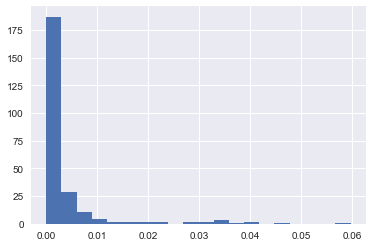

In [49]:
plt.hist(imp['imp'].values, bins=20);